# مشروع بناء نموذج تنبؤي لأمانة منطقة عسير

## الرخص الانشائية
*الفكره*
تطوير نموذج تنبؤ زمني لتحليل بيانات إصدار الرخص الإنشائية وفق التوزيع الشهري والأسبوعي، بهدف استكشاف الأنماط الموسمية وفترات الذروة والركود في الطلب على الرخص.
يشمل المشروع سلسلة مهام متكاملة تبدأ بتجهيز البيانات وتنظيفها، مرورًا بالتحليل الاستكشافي وفهم الأنماط الزمنية، ثم بناء نموذج تنبؤي متعدد الأبعاد، وأخيرًا تفسير النتائج ونشرها لدعم اتخاذ القرار في التخطيط العمراني والاستثماري.

## 0. تنزيل المكتبات و البيانات

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import joblib



In [2]:
df = pd.read_csv("الرخص الإنشائية.csv")
df.head()

,الأمانة,البلدية,البلدية التي درست الطلب,تاريخ اصدار الرخصة ميلادي,تاريخ نهاية الرخصة ميلادي,تاريخ تقديم الطلب,الغرض,حالة الرخصة,حالة الطلب,نوع سند الملكية
0,أمانة منطقة عسير,أمانة منطقة عسير,أمانة منطقة عسير,3/11/21 12:00:00 AM,1/29/25 12:00:00 AM,2/10/24 1:33:06 PM,تجديد رخصة بناء,منتهية,منتهى,عقد اسكان
1,أمانة منطقة عسير,بلدية طريب,بلدية طريب,10/7/20 12:00:00 AM,11/9/24 12:00:00 AM,11/21/23 8:32:23 PM,إضافة وتعديل مكونات رخصة بناء,منتهية,منتهى,صك
2,أمانة منطقة عسير,بلدية رجال المع,بلدية رجال المع,6/1/23 12:00:00 AM,5/20/24 12:00:00 AM,5/24/23 4:43:16 PM,إصدار تقرير فني,منتهية,منتهى,صك
3,أمانة منطقة عسير,بلدية بيشة,بلدية بيشة,4/7/13 12:00:00 AM,3/6/16 12:00:00 AM,8/7/24 6:48:04 PM,إدخال رخصة انشائية قديمة,منتهية,منتهى,صك
4,أمانة منطقة عسير,بلدية خميس مشيط,بلدية خميس مشيط,12/4/20 12:00:00 AM,11/3/23 12:00:00 AM,1/17/23 7:32:01 PM,إضافة وتعديل مكونات رخصة بناء,منتهية,منتهى,عقد اسكان


## 1. تحليل البيانات الأستكشافي

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26424 entries, 0 to 26423
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   الأمانة                    26424 non-null  object
 1   البلدية                    26424 non-null  object
 2   البلدية التي درست الطلب    26332 non-null  object
 3   تاريخ اصدار الرخصة ميلادي  26424 non-null  object
 4   تاريخ نهاية الرخصة ميلادي  26424 non-null  object
 5   تاريخ تقديم الطلب          26424 non-null  object
 6   الغرض                      26424 non-null  object
 7   حالة الرخصة                26424 non-null  object
 8   حالة الطلب                 26424 non-null  object
 9   نوع سند الملكية            26424 non-null  object
dtypes: object(10)
memory usage: 2.0+ MB


### 1.1 تحويل فئات الخصائص 

In [4]:
df.columns

Index(['الأمانة', 'البلدية', 'البلدية التي درست الطلب',
       'تاريخ اصدار الرخصة ميلادي', 'تاريخ نهاية الرخصة ميلادي',
       'تاريخ تقديم الطلب', 'الغرض', 'حالة الرخصة', 'حالة الطلب',
       'نوع سند الملكية'],
      dtype='object')

In [5]:
for col in df.columns:
    if df[col].dtype == 'object' and 'تاريخ' in col and 'هجري' not in col:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(f"Column '{col}' converted to datetime.")

C:\Users\USER\AppData\Local\Temp\ipykernel_17728\848563665.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


Column 'تاريخ اصدار الرخصة ميلادي' converted to datetime.


C:\Users\USER\AppData\Local\Temp\ipykernel_17728\848563665.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


Column 'تاريخ نهاية الرخصة ميلادي' converted to datetime.


C:\Users\USER\AppData\Local\Temp\ipykernel_17728\848563665.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


Column 'تاريخ تقديم الطلب' converted to datetime.


In [6]:
pd.set_option('display.max_columns', None)

In [7]:
df.sample()

,الأمانة,البلدية,البلدية التي درست الطلب,تاريخ اصدار الرخصة ميلادي,تاريخ نهاية الرخصة ميلادي,تاريخ تقديم الطلب,الغرض,حالة الرخصة,حالة الطلب,نوع سند الملكية
5990,أمانة منطقة عسير,أمانة منطقة عسير,أمانة منطقة عسير,2021-06-30,2025-05-27,2024-06-06 10:01:58,تجديد رخصة بناء,منتهية,منتهى,صك


### 1.2 التحقق من القيم المفقودة

In [8]:
for col in df.columns:
    if df[col].isnull().any():
        print(f"Column '{col}' has missing values.")
        print(df[col].isnull().sum(), "missing values")

Column 'البلدية التي درست الطلب' has missing values.
92 missing values


In [9]:
for col in df.columns:
    print(f"{col}: missing persentage is {df[col].isnull().sum() / len(df[col]) *100}%")

الأمانة: missing persentage is 0.0%
البلدية: missing persentage is 0.0%
البلدية التي درست الطلب: missing persentage is 0.348168331819558%
تاريخ اصدار الرخصة ميلادي: missing persentage is 0.0%
تاريخ نهاية الرخصة ميلادي: missing persentage is 0.0%
تاريخ تقديم الطلب: missing persentage is 0.0%
الغرض: missing persentage is 0.0%
حالة الرخصة: missing persentage is 0.0%
حالة الطلب: missing persentage is 0.0%
نوع سند الملكية: missing persentage is 0.0%


### 1.3 تعويض القيم المفقودة

In [10]:
df['البلدية التي درست الطلب'] = df['البلدية التي درست الطلب'].fillna(df['البلدية'])


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26424 entries, 0 to 26423
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   الأمانة                    26424 non-null  object        
 1   البلدية                    26424 non-null  object        
 2   البلدية التي درست الطلب    26424 non-null  object        
 3   تاريخ اصدار الرخصة ميلادي  26424 non-null  datetime64[ns]
 4   تاريخ نهاية الرخصة ميلادي  26424 non-null  datetime64[ns]
 5   تاريخ تقديم الطلب          26424 non-null  datetime64[ns]
 6   الغرض                      26424 non-null  object        
 7   حالة الرخصة                26424 non-null  object        
 8   حالة الطلب                 26424 non-null  object        
 9   نوع سند الملكية            26424 non-null  object        
dtypes: datetime64[ns](3), object(7)
memory usage: 2.0+ MB


### 1.4 ماهو مدى البيانات

In [12]:
print(" Minimum date:", df['تاريخ تقديم الطلب'].min())
print(" Maximum date:", df['تاريخ تقديم الطلب'].max())

 Minimum date: 2023-01-01 08:29:31
 Maximum date: 2024-12-31 21:07:18


In [13]:
print("Minimum date:", df['تاريخ اصدار الرخصة ميلادي'].min())
print("Maximum date:", df['تاريخ اصدار الرخصة ميلادي'].max())

Minimum date: 1975-03-31 00:00:00
Maximum date: 2074-10-25 00:00:00


### 1.5 ماهي القيم داخل الأعمدة

In [14]:
for col in df.columns:
    if df[col].dtype == 'object' and 'تاريخ' not in col:
        unique_values = df[col].unique()
        print(f"Column '{col}' has {len(unique_values)} unique values.")

Column 'الأمانة' has 1 unique values.
Column 'البلدية' has 37 unique values.
Column 'البلدية التي درست الطلب' has 37 unique values.
Column 'الغرض' has 13 unique values.
Column 'حالة الرخصة' has 4 unique values.
Column 'حالة الطلب' has 1 unique values.
Column 'نوع سند الملكية' has 6 unique values.


In [15]:
for col in df.columns:
    if df[col].dtype == 'object' and 'تاريخ' not in col:
        values = df[col].value_counts()
        print(f"Column '{col}' value counts:")
        print(values)
        print("\n")


Column 'الأمانة' value counts:
الأمانة
أمانة منطقة عسير    26424
Name: count, dtype: int64


Column 'البلدية' value counts:
البلدية
بلدية خميس مشيط         6714
أمانة منطقة عسير        5106
بلدية بيشة              2678
بلدية محايل عسير        2152
بلدية تثليث             1764
بلدية احد رفيدة         1634
بلدية النماص             739
بللقرن                   669
بلدية سراة عبيده         600
بلدية المجاردة           535
بلدية ظهران الجنوب       382
بلدية بارق               363
بلدية طريب               354
بلدية الواديين           328
بلدية وادي هشبل          316
بلدية الحرجة             251
بلدية الحازمي            174
بلدية البشائر            165
نطاق خدمة مدينة أبها     159
بلدية ثنية وتباله        152
بلدية تنومه              146
بلدية الساحل             140
بلدية بللسمر             117
بلدية النقيع             116
فرع مدينة سلطان          105
بلدية الامواه            103
بلدية رجال المع           88
بلدية صمخ                 71
بلدية البرك               70
بلدية الفرشة              6

## 2. تحليل البيانات 

### 2.1 مدة صلاحية الرخصة

In [16]:
df['مدة صلاحية الرخصة'] = df['تاريخ نهاية الرخصة ميلادي'] - df['تاريخ اصدار الرخصة ميلادي']
df['مدة صلاحية الرخصة'] =df['مدة صلاحية الرخصة'].dt.days / 30 / 12 
df['مدة صلاحية الرخصة'] = df['مدة صلاحية الرخصة'].round()

df['مدة صلاحية الرخصة'].unique()


array([  4.,   1.,   3.,   6.,  17.,   5.,  12.,  28.,   7.,  11.,  19.,
        23.,  10.,   9.,  16.,   2.,  40.,   8.,  14.,  15.,  24.,   0.,
        41.,  37.,  42.,  33.,  38.,  13.,  26.,  30.,  32.,  45.,  35.,
        43.,  31.,  44.,  25.,  18.,  29.,  22.,  21., -10.,  20.,  39.,
        49.,  27.,  34.,  50.,  36.,  46.,  48.,  47., -48., -77., -99.])

In [17]:
negative_validity = df[df['مدة صلاحية الرخصة'] < 0]
negative_validity


,الأمانة,البلدية,البلدية التي درست الطلب,تاريخ اصدار الرخصة ميلادي,تاريخ نهاية الرخصة ميلادي,تاريخ تقديم الطلب,الغرض,حالة الرخصة,حالة الطلب,نوع سند الملكية,مدة صلاحية الرخصة
1753,أمانة منطقة عسير,بلدية ظهران الجنوب,بلدية ظهران الجنوب,2028-09-17,2018-12-10,2023-02-07 20:01:03,إدخال رخصة انشائية قديمة,منتهية,منتهى,صك,-10.0
19523,أمانة منطقة عسير,أمانة منطقة عسير,أمانة منطقة عسير,2073-04-23,2025-12-22,2024-09-25 09:53:13,تجديد رخصة بناء,سارية,منتهى,صك,-48.0
23565,أمانة منطقة عسير,بلدية خميس مشيط,بلدية خميس مشيط,2072-06-07,1996-09-09,2023-03-28 22:21:29,نقل ملكية رخصة بناء فورية,منتهية,منتهى,صك,-77.0
24258,أمانة منطقة عسير,بلدية خميس مشيط,بلدية خميس مشيط,2074-10-25,1977-09-23,2024-12-26 09:23:29,إدخال رخصة انشائية قديمة,منتهية,منتهى,صك,-99.0


In [18]:
df = df[df['مدة صلاحية الرخصة'] >= 0]


In [19]:
print("Minimum renewal period:", df['مدة صلاحية الرخصة'].min(), "years")
print("Maximum renewal period:", df['مدة صلاحية الرخصة'].max(), "years")

df['مدة صلاحية الرخصة'].describe()

Minimum renewal period: 0.0 years
Maximum renewal period: 50.0 years


count    26420.000000
mean         4.038191
std          4.311346
min          0.000000
25%          3.000000
50%          3.000000
75%          3.000000
max         50.000000
Name: مدة صلاحية الرخصة, dtype: float64

In [20]:
print('number of linceses has validity more than 10 years:', df[df['مدة صلاحية الرخصة'] > 40].shape[0])

number of linceses has validity more than 10 years: 74


Text(0.5, 0, 'Validity Period (Years)')

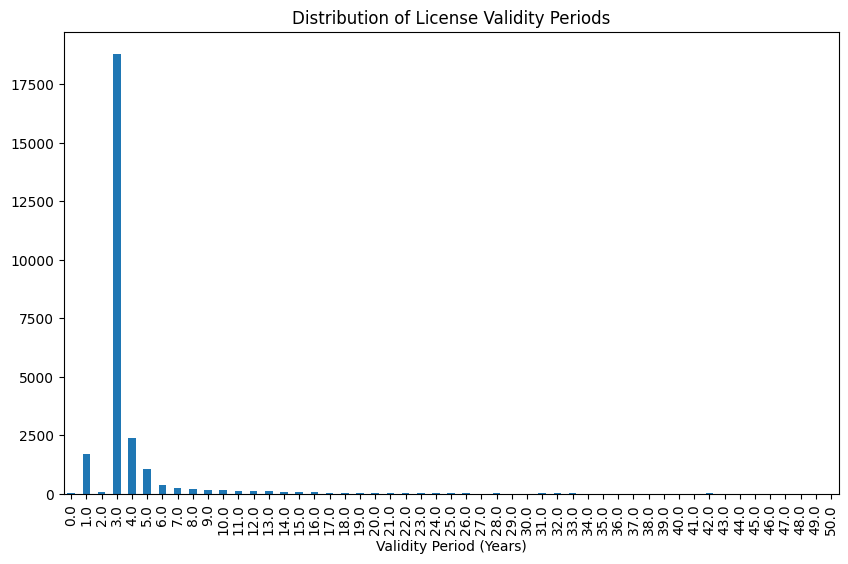

In [21]:

plt.figure(figsize=(10, 6)) 
df['مدة صلاحية الرخصة'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of License Validity Periods')
plt.xlabel('Validity Period (Years)')

#### 2.1.1 انشاء عمود فئة صلاحية الرخصة

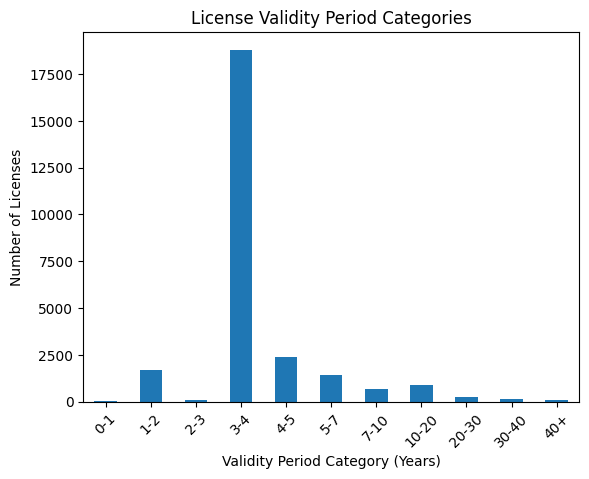

In [22]:
df['فئة مدة صلاحية الرخصة'] = pd.cut(
    df['مدة صلاحية الرخصة'],
    bins=[0, 1, 2, 3, 4, 5, 7, 10, 20, 30, 40, float('inf')],
    labels=['0-1', '1-2', '2-3', '3-4', '4-5', '5-7', '7-10', '10-20', '20-30', '30-40', '40+'],
    right=False
)
df['فئة مدة صلاحية الرخصة'].value_counts().sort_index().plot(kind='bar')
plt.title('License Validity Period Categories')
plt.xlabel('Validity Period Category (Years)')
plt.ylabel('Number of Licenses')
plt.xticks(rotation=45)
plt.show()
                                    

In [23]:
df['فئة مدة صلاحية الرخصة'] = df['فئة مدة صلاحية الرخصة'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26420 entries, 0 to 26423
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   الأمانة                    26420 non-null  object        
 1   البلدية                    26420 non-null  object        
 2   البلدية التي درست الطلب    26420 non-null  object        
 3   تاريخ اصدار الرخصة ميلادي  26420 non-null  datetime64[ns]
 4   تاريخ نهاية الرخصة ميلادي  26420 non-null  datetime64[ns]
 5   تاريخ تقديم الطلب          26420 non-null  datetime64[ns]
 6   الغرض                      26420 non-null  object        
 7   حالة الرخصة                26420 non-null  object        
 8   حالة الطلب                 26420 non-null  object        
 9   نوع سند الملكية            26420 non-null  object        
 10  مدة صلاحية الرخصة          26420 non-null  float64       
 11  فئة مدة صلاحية الرخصة      26420 non-null  object        
dtypes: dateti

### 2.2 تحليل تنوع القيم في الخصائص

In [24]:
df.columns

Index(['الأمانة', 'البلدية', 'البلدية التي درست الطلب',
       'تاريخ اصدار الرخصة ميلادي', 'تاريخ نهاية الرخصة ميلادي',
       'تاريخ تقديم الطلب', 'الغرض', 'حالة الرخصة', 'حالة الطلب',
       'نوع سند الملكية', 'مدة صلاحية الرخصة', 'فئة مدة صلاحية الرخصة'],
      dtype='object')

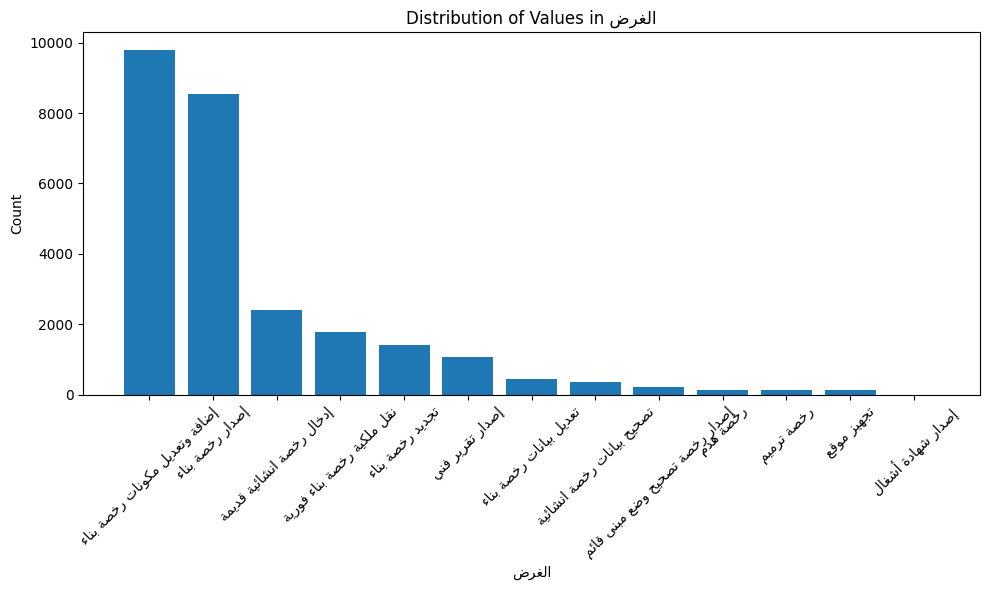

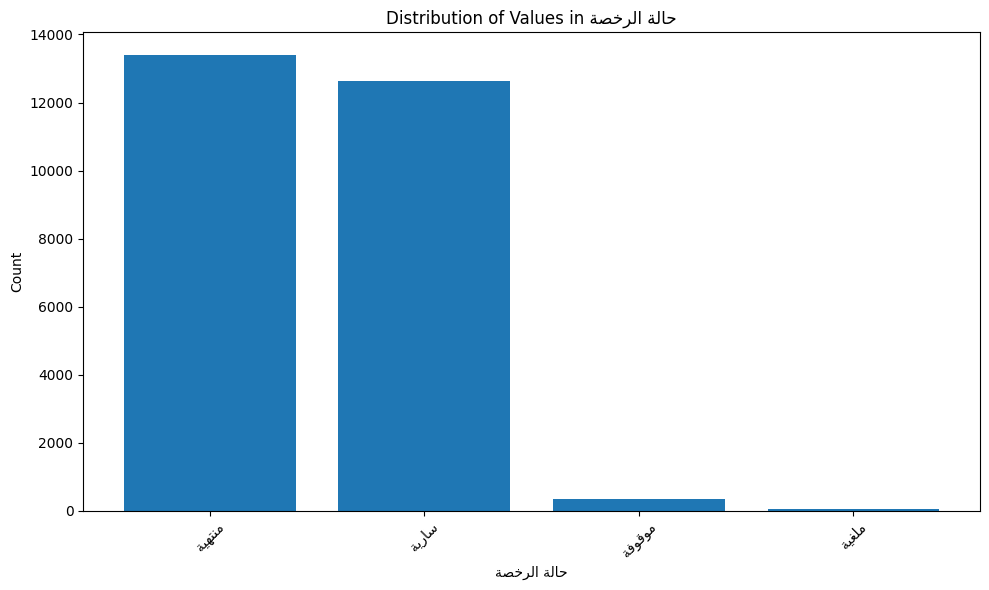

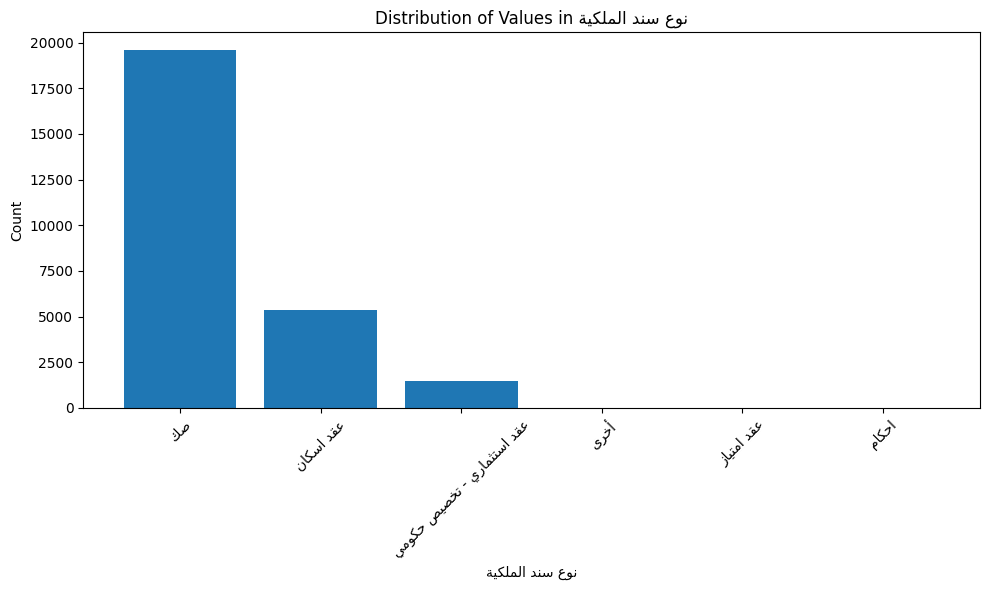

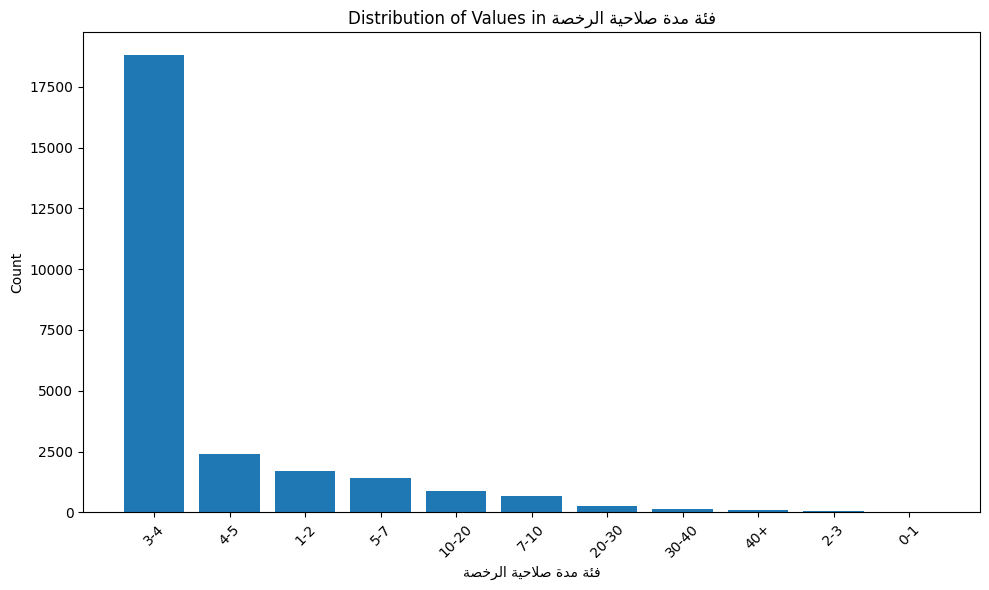

In [25]:

for col in df.columns:
    if df[col].dtype == 'object' and 'تاريخ' not in col and df[col].nunique() > 1:
        value_counts = df[col].value_counts()
        
        if len(value_counts) < 20:
            reshaped_labels = [get_display(arabic_reshaper.reshape(str(label))) for label in value_counts.index]
            
            plt.figure(figsize=(10, 6))
            plt.bar(reshaped_labels, value_counts.values)
            
            reshaped_title = get_display(arabic_reshaper.reshape(col))
            plt.title(f'Distribution of Values in {reshaped_title}')
            plt.xlabel(reshaped_title)
            plt.ylabel('Count')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()


In [26]:
df.columns

Index(['الأمانة', 'البلدية', 'البلدية التي درست الطلب',
       'تاريخ اصدار الرخصة ميلادي', 'تاريخ نهاية الرخصة ميلادي',
       'تاريخ تقديم الطلب', 'الغرض', 'حالة الرخصة', 'حالة الطلب',
       'نوع سند الملكية', 'مدة صلاحية الرخصة', 'فئة مدة صلاحية الرخصة'],
      dtype='object')

### 2.3 مصفوفه الارتباط

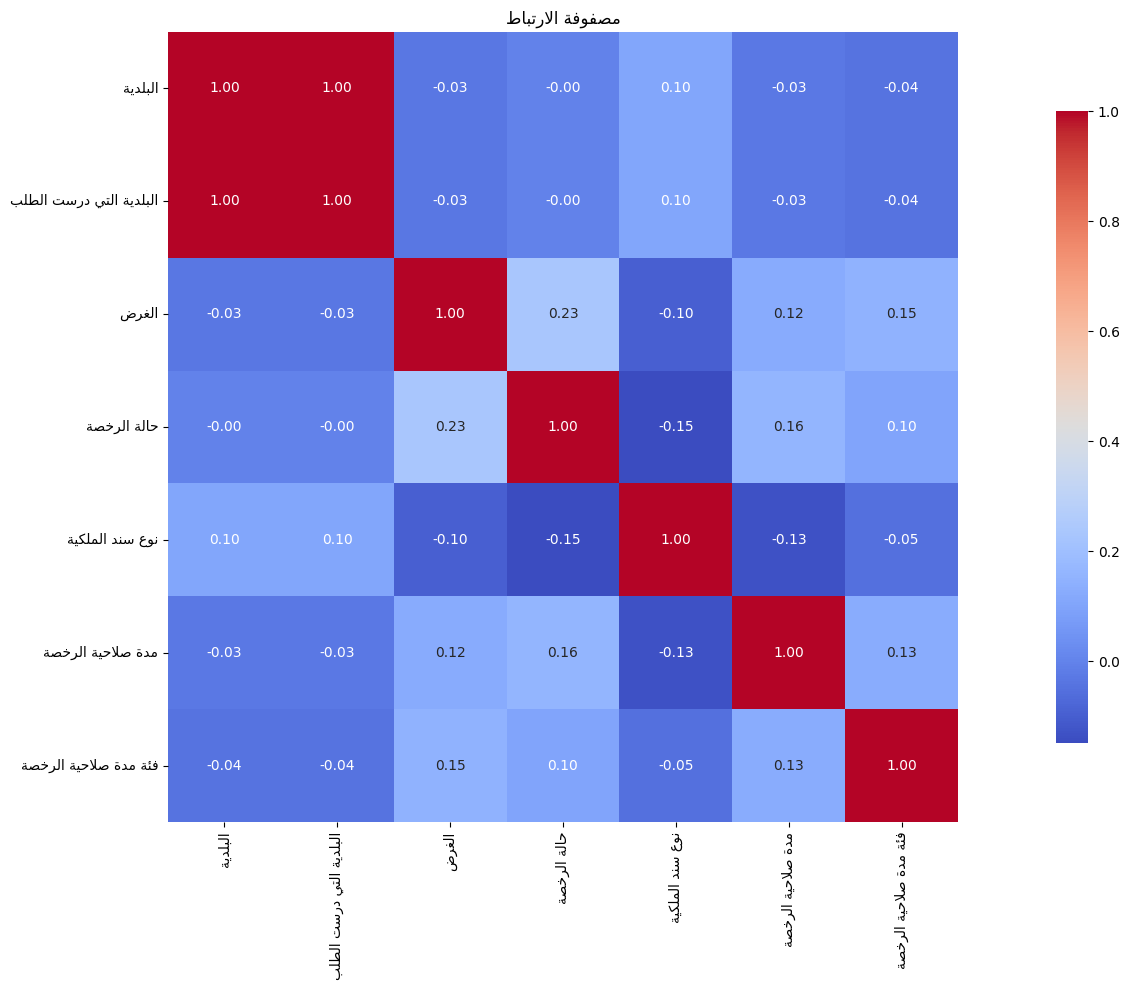

In [27]:


data = df.copy()
for col in data.columns:
    if data[col].dtype == 'object' and 'تاريخ' not in col and data[col].nunique() > 1:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))

corr_matrix = data.corr(numeric_only=True)

# corr_matrix = corr_matrix.iloc[1:, 1:]

reshaped_labels = [get_display(arabic_reshaper.reshape(str(label))) for label in corr_matrix.columns]
corr_matrix.columns = reshaped_labels
corr_matrix.index = reshaped_labels

plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title(get_display(arabic_reshaper.reshape('مصفوفة الارتباط'))) 
plt.tight_layout()
plt.show()


In [28]:
df.sample()

,الأمانة,البلدية,البلدية التي درست الطلب,تاريخ اصدار الرخصة ميلادي,تاريخ نهاية الرخصة ميلادي,تاريخ تقديم الطلب,الغرض,حالة الرخصة,حالة الطلب,نوع سند الملكية,مدة صلاحية الرخصة,فئة مدة صلاحية الرخصة
1880,أمانة منطقة عسير,بلدية احد رفيدة,بلدية احد رفيدة,2016-11-13,2023-08-17,2023-05-16 18:49:16,نقل ملكية رخصة بناء فورية,منتهية,منتهى,صك,7.0,7-10


In [29]:
data.sample()

,الأمانة,البلدية,البلدية التي درست الطلب,تاريخ اصدار الرخصة ميلادي,تاريخ نهاية الرخصة ميلادي,تاريخ تقديم الطلب,الغرض,حالة الرخصة,حالة الطلب,نوع سند الملكية,مدة صلاحية الرخصة,فئة مدة صلاحية الرخصة
21643,أمانة منطقة عسير,20,20,2022-11-06,2025-10-04,2023-05-16 10:26:20,5,0,منتهى,2,3.0,5


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26420 entries, 0 to 26423
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   الأمانة                    26420 non-null  object        
 1   البلدية                    26420 non-null  int64         
 2   البلدية التي درست الطلب    26420 non-null  int64         
 3   تاريخ اصدار الرخصة ميلادي  26420 non-null  datetime64[ns]
 4   تاريخ نهاية الرخصة ميلادي  26420 non-null  datetime64[ns]
 5   تاريخ تقديم الطلب          26420 non-null  datetime64[ns]
 6   الغرض                      26420 non-null  int64         
 7   حالة الرخصة                26420 non-null  int64         
 8   حالة الطلب                 26420 non-null  object        
 9   نوع سند الملكية            26420 non-null  int64         
 10  مدة صلاحية الرخصة          26420 non-null  float64       
 11  فئة مدة صلاحية الرخصة      26420 non-null  int64         
dtypes: dateti

توجد خصائص متشابهه

### 2.4 تحليل الارتباط التاريخي

In [31]:
for col in df.columns:
    if 'تاريخ' in col:
        print(col)

تاريخ اصدار الرخصة ميلادي
تاريخ نهاية الرخصة ميلادي
تاريخ تقديم الطلب


In [32]:
for col in df.columns:
    if 'تاريخ' in col and 'هجري' not in col:
        print(col)

تاريخ اصدار الرخصة ميلادي
تاريخ نهاية الرخصة ميلادي
تاريخ تقديم الطلب


In [33]:
df.columns

Index(['الأمانة', 'البلدية', 'البلدية التي درست الطلب',
       'تاريخ اصدار الرخصة ميلادي', 'تاريخ نهاية الرخصة ميلادي',
       'تاريخ تقديم الطلب', 'الغرض', 'حالة الرخصة', 'حالة الطلب',
       'نوع سند الملكية', 'مدة صلاحية الرخصة', 'فئة مدة صلاحية الرخصة'],
      dtype='object')

In [34]:
collection = ['البلدية','الغرض','نوع سند الملكية','فئة مدة صلاحية الرخصة']
for col in collection:
    # pass
    print(df[col].value_counts())
    print(f'{col}: {df[col].dtype}')


البلدية
بلدية خميس مشيط         6712
أمانة منطقة عسير        5105
بلدية بيشة              2678
بلدية محايل عسير        2152
بلدية تثليث             1764
بلدية احد رفيدة         1634
بلدية النماص             739
بللقرن                   669
بلدية سراة عبيده         600
بلدية المجاردة           535
بلدية ظهران الجنوب       381
بلدية بارق               363
بلدية طريب               354
بلدية الواديين           328
بلدية وادي هشبل          316
بلدية الحرجة             251
بلدية الحازمي            174
بلدية البشائر            165
نطاق خدمة مدينة أبها     159
بلدية ثنية وتباله        152
بلدية تنومه              146
بلدية الساحل             140
بلدية بللسمر             117
بلدية النقيع             116
فرع مدينة سلطان          105
بلدية الامواه            103
بلدية رجال المع           88
بلدية صمخ                 71
بلدية البرك               70
بلدية الفرشة              61
بلدية الصبيخة             43
بحر ابو سكينة             34
بلدية بني عمرو            31
بللحمر                    22
بلدية 

In [35]:
weekday_map = {
    'Sunday': 'الأحد',
    'Monday': 'الإثنين',
    'Tuesday': 'الثلاثاء',
    'Wednesday': 'الأربعاء',
    'Thursday': 'الخميس',
    'Friday': 'الجمعة',
    'Saturday': 'السبت'
}

In [36]:
df['سنة الطلب'] = df['تاريخ تقديم الطلب'].dt.year
df['شهر الطلب'] = df['تاريخ تقديم الطلب'].dt.month
df['أسبوع الطلب'] = df['تاريخ تقديم الطلب'].dt.isocalendar().week
df['يوم الأسبوع'] = df['تاريخ تقديم الطلب'].dt.day_name().map(weekday_map)
df['يوم الطلب'] = df['تاريخ تقديم الطلب'].dt.day

In [37]:
df.sample()

,الأمانة,البلدية,البلدية التي درست الطلب,تاريخ اصدار الرخصة ميلادي,تاريخ نهاية الرخصة ميلادي,تاريخ تقديم الطلب,الغرض,حالة الرخصة,حالة الطلب,نوع سند الملكية,مدة صلاحية الرخصة,فئة مدة صلاحية الرخصة,سنة الطلب,شهر الطلب,أسبوع الطلب,يوم الأسبوع,يوم الطلب
23423,أمانة منطقة عسير,بلدية الساحل,بلدية الساحل,2022-11-19,2025-10-17,2023-05-15 21:38:46,إضافة وتعديل مكونات رخصة بناء,سارية,منتهى,صك,3.0,3-4,2023,5,20,الإثنين,15


In [38]:
columns_needed = collection + ['تاريخ تقديم الطلب', 'سنة الطلب', 'شهر الطلب', 'أسبوع الطلب', 'يوم الطلب', 'يوم الأسبوع']
dataframe = df[columns_needed]
dataframe.head()

,البلدية,الغرض,نوع سند الملكية,فئة مدة صلاحية الرخصة,تاريخ تقديم الطلب,سنة الطلب,شهر الطلب,أسبوع الطلب,يوم الطلب,يوم الأسبوع
0,أمانة منطقة عسير,تجديد رخصة بناء,عقد اسكان,4-5,2024-02-10 13:33:06,2024,2,6,10,السبت
1,بلدية طريب,إضافة وتعديل مكونات رخصة بناء,صك,4-5,2023-11-21 20:32:23,2023,11,47,21,الثلاثاء
2,بلدية رجال المع,إصدار تقرير فني,صك,1-2,2023-05-24 16:43:16,2023,5,21,24,الأربعاء
3,بلدية بيشة,إدخال رخصة انشائية قديمة,صك,3-4,2024-08-07 18:48:04,2024,8,32,7,الأربعاء
4,بلدية خميس مشيط,إضافة وتعديل مكونات رخصة بناء,عقد اسكان,3-4,2023-01-17 19:32:01,2023,1,3,17,الثلاثاء


In [39]:
columns_needed

['البلدية',
 'الغرض',
 'نوع سند الملكية',
 'فئة مدة صلاحية الرخصة',
 'تاريخ تقديم الطلب',
 'سنة الطلب',
 'شهر الطلب',
 'أسبوع الطلب',
 'يوم الطلب',
 'يوم الأسبوع']

In [40]:
def reshape_arabic(text):
    return get_display(arabic_reshaper.reshape(text))

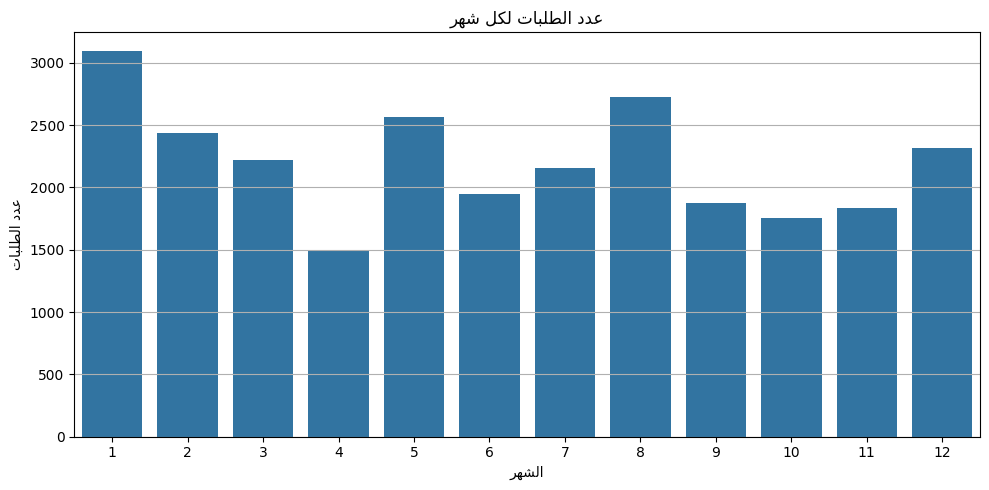

In [41]:
plt.figure(figsize=(10, 5))
sns.countplot(data=dataframe, x='شهر الطلب', order=sorted(dataframe['شهر الطلب'].unique()))
plt.title(reshape_arabic('عدد الطلبات لكل شهر'))
plt.xlabel(reshape_arabic('الشهر'))
plt.ylabel(reshape_arabic('عدد الطلبات'))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

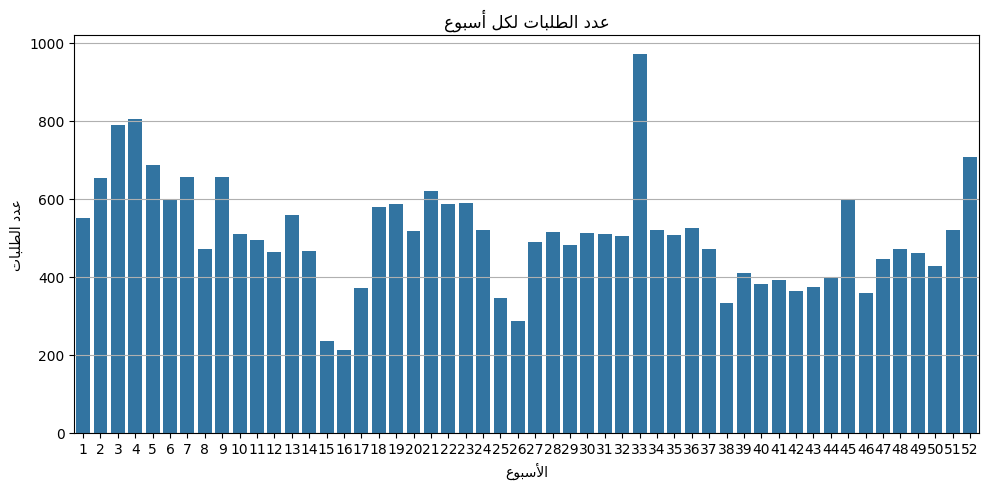

In [42]:
plt.figure(figsize=(10, 5))
sns.countplot(data=dataframe, x='أسبوع الطلب', order=sorted(dataframe['أسبوع الطلب'].unique()))
plt.title(reshape_arabic('عدد الطلبات لكل أسبوع'))
plt.xlabel(reshape_arabic('الأسبوع'))
plt.ylabel(reshape_arabic('عدد الطلبات'))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [43]:
dataframe.columns

Index(['البلدية', 'الغرض', 'نوع سند الملكية', 'فئة مدة صلاحية الرخصة',
       'تاريخ تقديم الطلب', 'سنة الطلب', 'شهر الطلب', 'أسبوع الطلب',
       'يوم الطلب', 'يوم الأسبوع'],
      dtype='object')

C:\Users\USER\AppData\Local\Temp\ipykernel_17728\101200610.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['يوم الأسبوع (عرض)'] = dataframe['يوم الأسبوع'].apply(reshape_arabic)


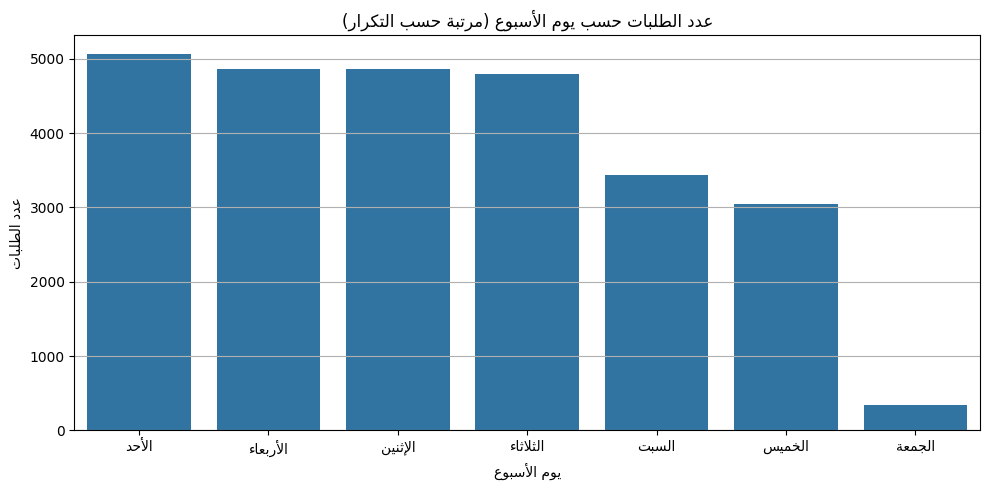

In [44]:
weekday_order = dataframe['يوم الأسبوع'].value_counts().index.tolist()
reshaped_order = [reshape_arabic(day) for day in weekday_order]

dataframe['يوم الأسبوع (عرض)'] = dataframe['يوم الأسبوع'].apply(reshape_arabic)

plt.figure(figsize=(10, 5))
sns.countplot(data=dataframe, x='يوم الأسبوع (عرض)', order=reshaped_order)
plt.title(reshape_arabic('عدد الطلبات حسب يوم الأسبوع (مرتبة حسب التكرار)'))
plt.xlabel(reshape_arabic('يوم الأسبوع'))
plt.ylabel(reshape_arabic('عدد الطلبات'))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [45]:
dataframe.columns

Index(['البلدية', 'الغرض', 'نوع سند الملكية', 'فئة مدة صلاحية الرخصة',
       'تاريخ تقديم الطلب', 'سنة الطلب', 'شهر الطلب', 'أسبوع الطلب',
       'يوم الطلب', 'يوم الأسبوع', 'يوم الأسبوع (عرض)'],
      dtype='object')

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\

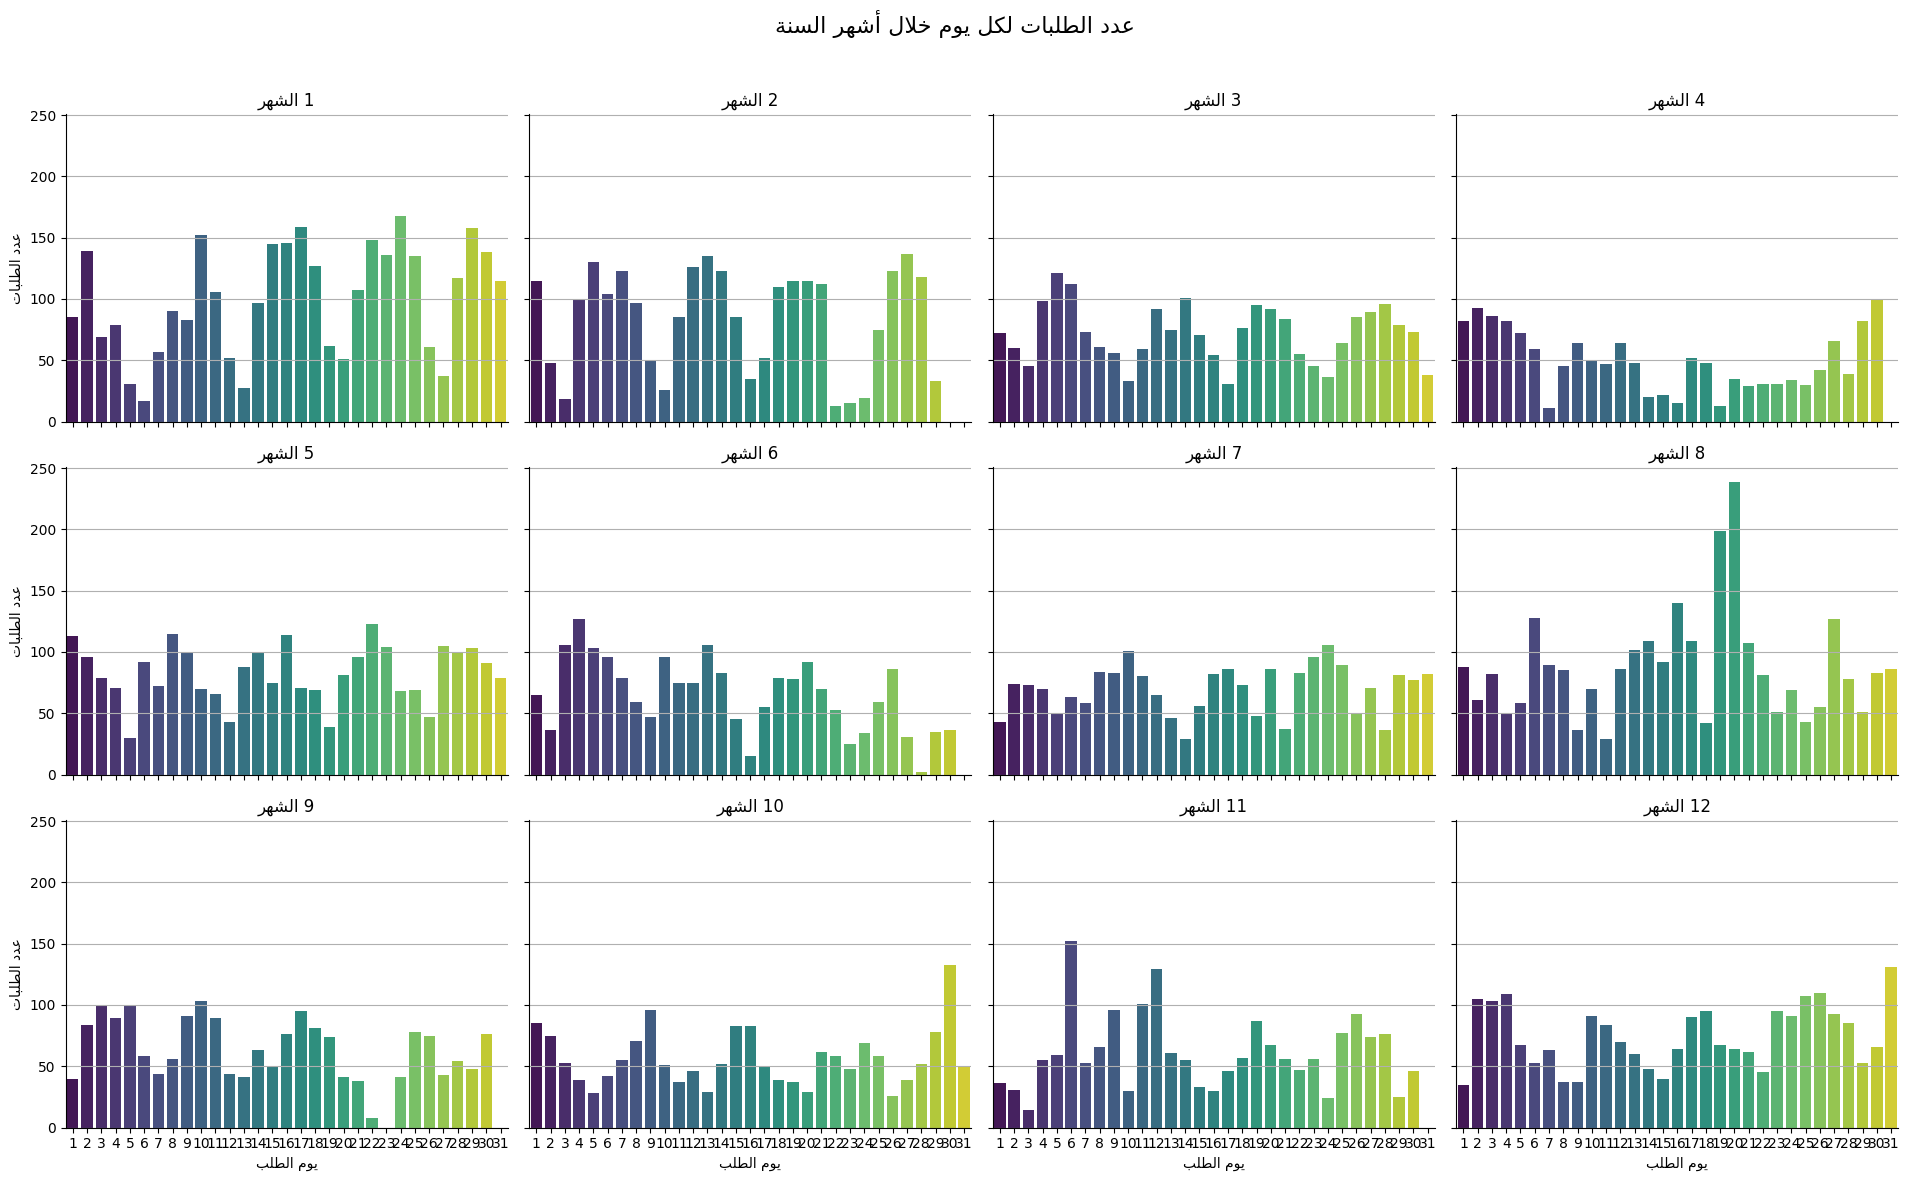

In [46]:
g = sns.FacetGrid(dataframe, col='شهر الطلب', col_wrap=4, height=4, aspect=1.2)
g.map(sns.countplot, 'يوم الطلب', order=range(1, 32), palette='viridis')

for ax in g.axes.flat:
    ax.set_title(reshape_arabic('الشهر') + f" {int(ax.get_title().split('=')[1])}")
    ax.set_xlabel(reshape_arabic('يوم الطلب'))
    ax.set_ylabel(reshape_arabic('عدد الطلبات'))
    ax.grid(axis='y')

plt.suptitle(reshape_arabic('عدد الطلبات لكل يوم خلال أشهر السنة'), fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # لتجنب تغطية العنوان الرئيسي
plt.show()

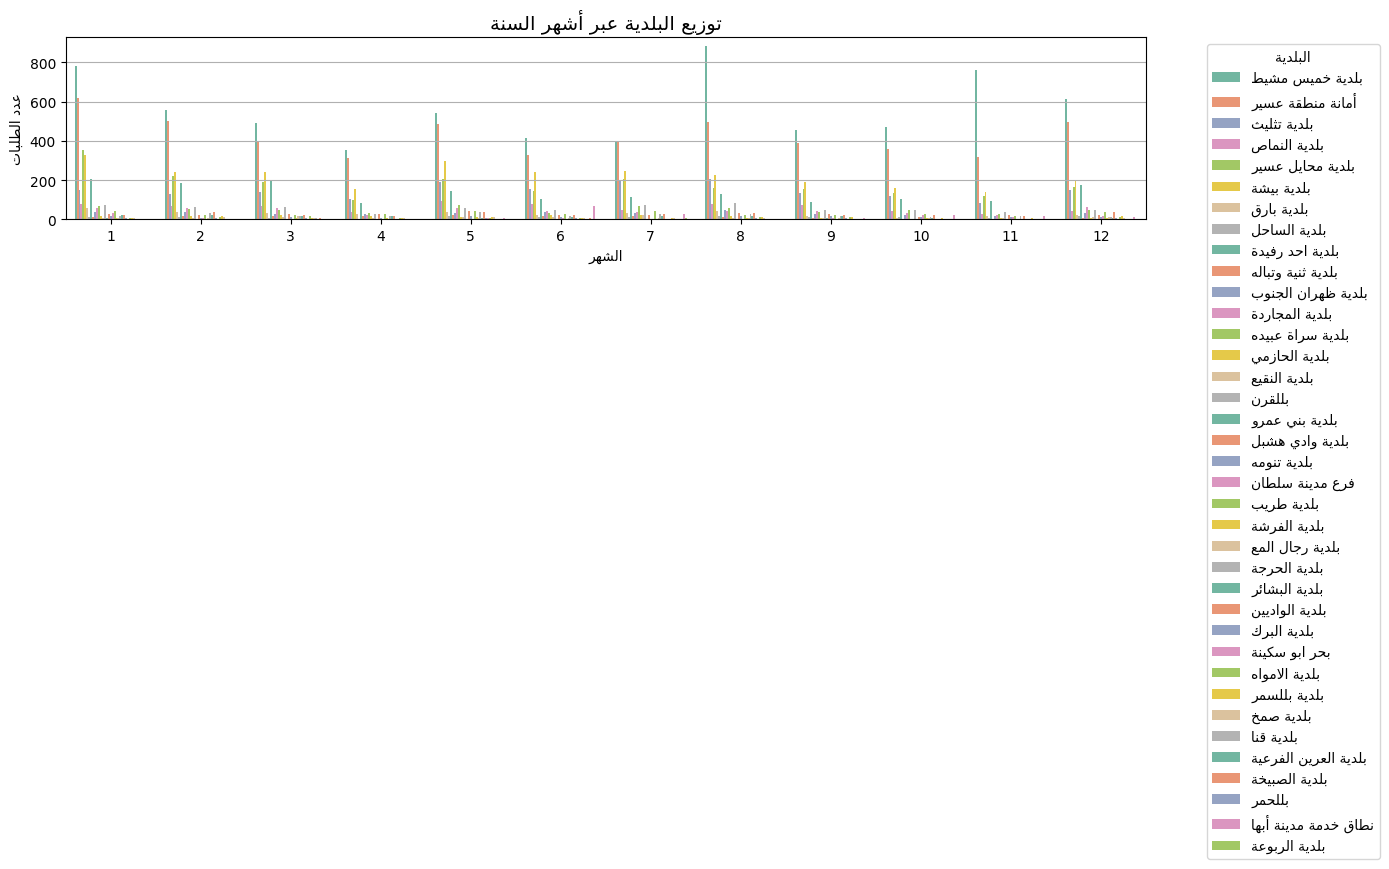

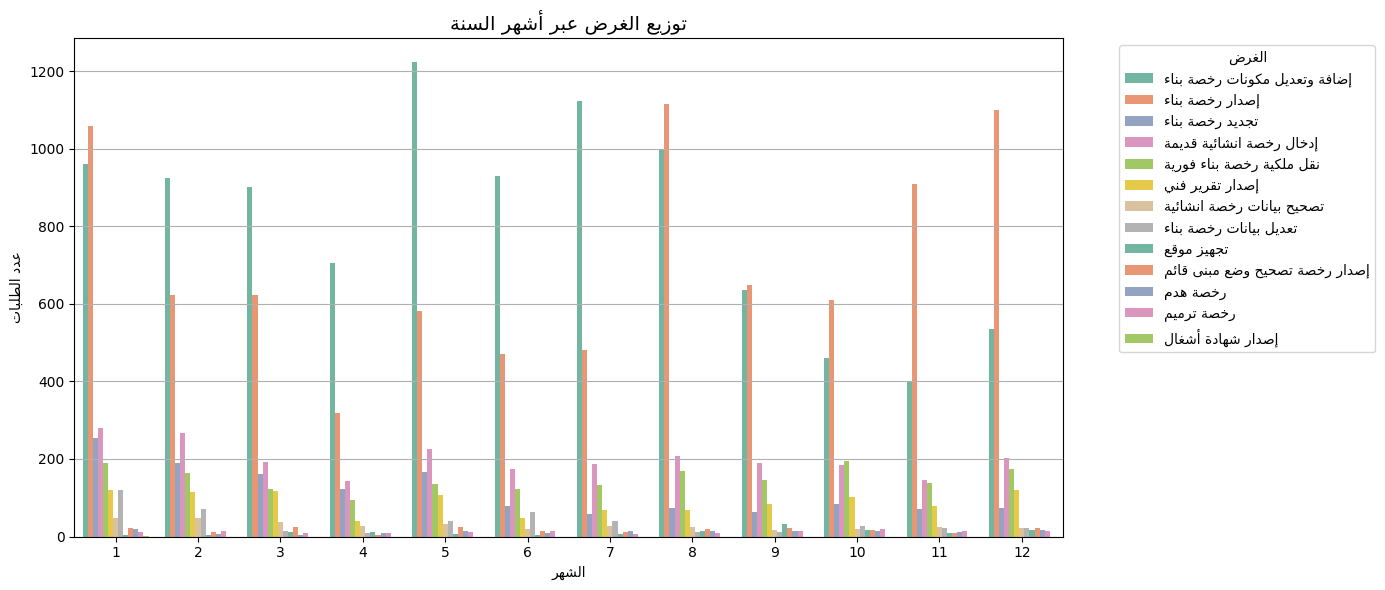

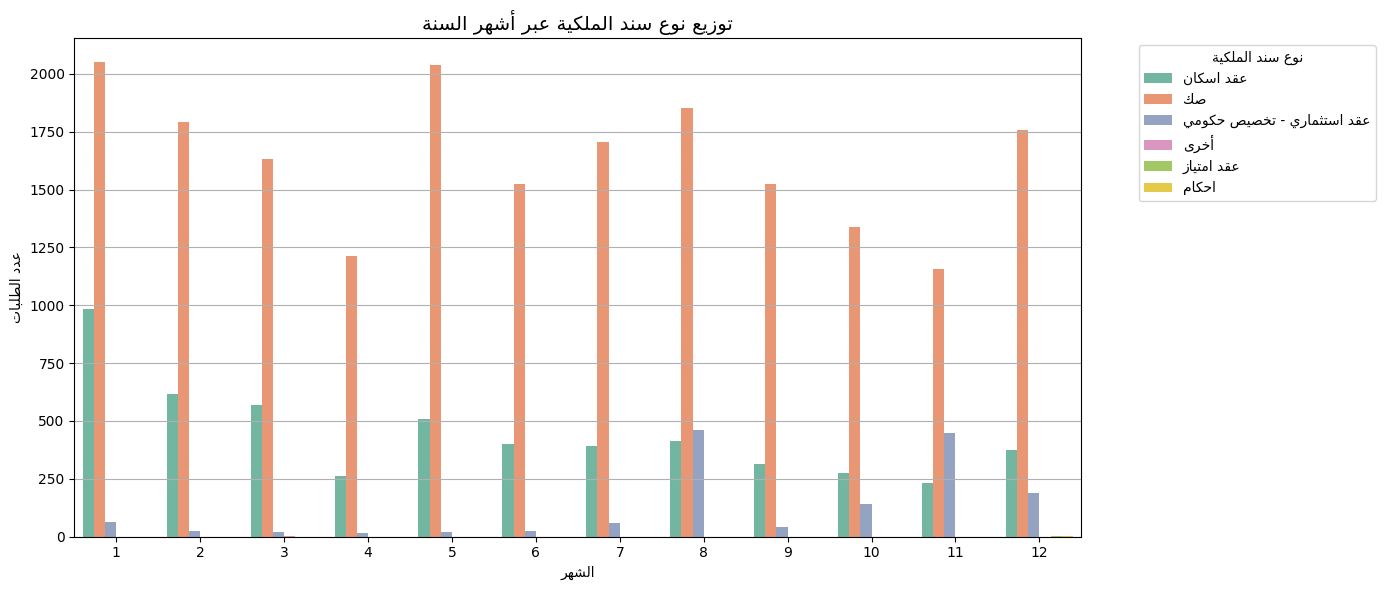

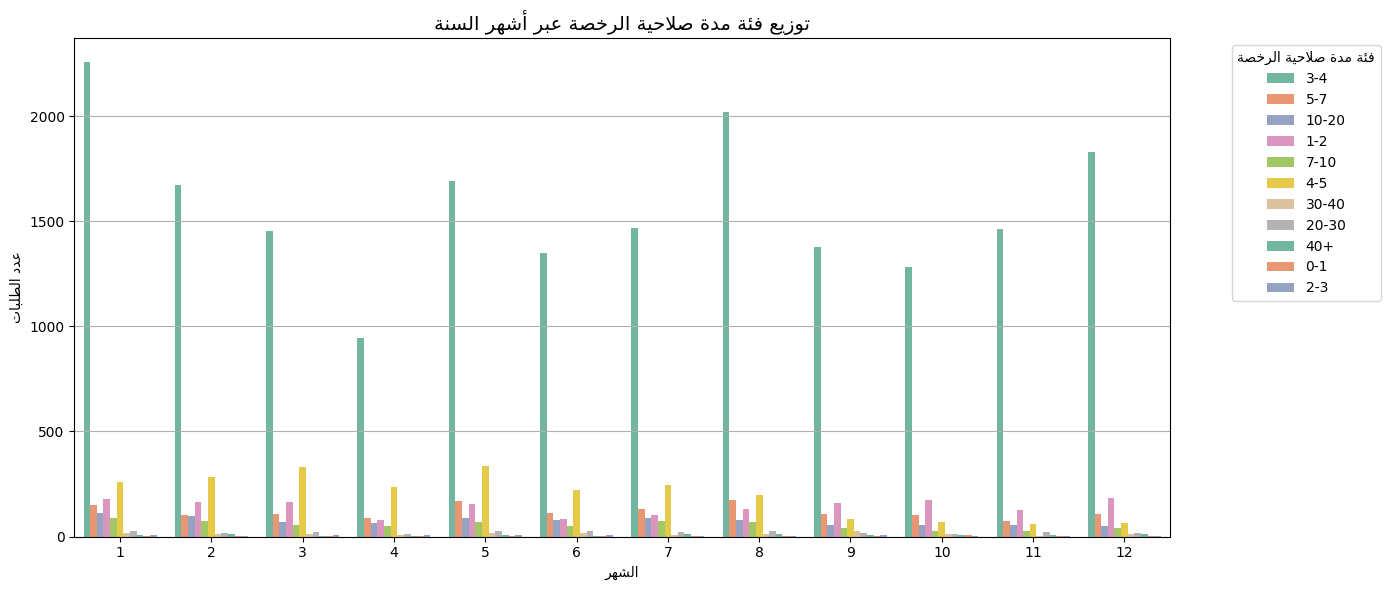

In [47]:

# Optional: limit number of categories per column to show (to avoid clutter)
# top_n = 5

for col in collection:
    categories = dataframe[col].value_counts().index
    df_filtered = dataframe[dataframe[col].isin(categories)].copy()

    df_filtered['category_reshaped'] = df_filtered[col].astype(str).apply(reshape_arabic)

    # Plot
    plt.figure(figsize=(14, 6))
    sns.countplot(
        data=df_filtered,
        x='شهر الطلب',
        hue='category_reshaped',
        palette='Set2'
    )

    plt.title(reshape_arabic(f'توزيع {col} عبر أشهر السنة'), fontsize=14)
    plt.xlabel(reshape_arabic('الشهر'))
    plt.ylabel(reshape_arabic('عدد الطلبات'))
    plt.legend(title=reshape_arabic(col), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


In [48]:
df.to_csv("v1الرخص الإنشائية.csv")

## 3. بناء النموذج التنبؤي
بعد الانتهاء من تحليل البيانات الزمنية واستخلاص الأنماط الموسمية، نقوم ببناء نموذج تنبؤ زمني متعدد الأبعاد يهدف إلى تقدير حجم الطلب على الرخص الإنشائية بشكل شهري وأسبوعي. كما يشمل النموذج التنبؤ بأنواع الطلبات والأنشطة الإنشائية المرتبطة بها. 

In [49]:
dataframe.columns

Index(['البلدية', 'الغرض', 'نوع سند الملكية', 'فئة مدة صلاحية الرخصة',
       'تاريخ تقديم الطلب', 'سنة الطلب', 'شهر الطلب', 'أسبوع الطلب',
       'يوم الطلب', 'يوم الأسبوع', 'يوم الأسبوع (عرض)'],
      dtype='object')

In [50]:
dataframe.sample()

,البلدية,الغرض,نوع سند الملكية,فئة مدة صلاحية الرخصة,تاريخ تقديم الطلب,سنة الطلب,شهر الطلب,أسبوع الطلب,يوم الطلب,يوم الأسبوع,يوم الأسبوع (عرض)
19686,بلدية طريب,نقل ملكية رخصة بناء فورية,صك,3-4,2024-01-22 10:52:32,2024,1,4,22,الإثنين,ﻦﻴﻨﺛﻹﺍ


In [51]:
columns_needed

['البلدية',
 'الغرض',
 'نوع سند الملكية',
 'فئة مدة صلاحية الرخصة',
 'تاريخ تقديم الطلب',
 'سنة الطلب',
 'شهر الطلب',
 'أسبوع الطلب',
 'يوم الطلب',
 'يوم الأسبوع']

In [52]:
dataframe[dataframe.columns[:-1]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 26420 entries, 0 to 26423
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   البلدية                26420 non-null  object        
 1   الغرض                  26420 non-null  object        
 2   نوع سند الملكية        26420 non-null  object        
 3   فئة مدة صلاحية الرخصة  26420 non-null  object        
 4   تاريخ تقديم الطلب      26420 non-null  datetime64[ns]
 5   سنة الطلب              26420 non-null  int32         
 6   شهر الطلب              26420 non-null  int32         
 7   أسبوع الطلب            26420 non-null  UInt32        
 8   يوم الطلب              26420 non-null  int32         
 9   يوم الأسبوع            26420 non-null  object        
dtypes: UInt32(1), datetime64[ns](1), int32(3), object(5)
memory usage: 1.8+ MB


In [53]:


def encode_and_save_encoders(df, columns, encoder_path="label_encoders.pkl"):
    """
    Encodes categorical columns using LabelEncoder and saves the encoders.
    
    Parameters:
        df: DataFrame to encode
        columns: List of column names to encode
        encoder_path: Path to save the encoder dictionary
    
    Returns:
        Encoded DataFrame
    """
    encoders = {}
    
    for col in columns:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            encoders[col] = le  # Save encoder for later use
    
    # Save all encoders to disk
    joblib.dump(encoders, encoder_path)
    print(f"✅ Encoders saved to {encoder_path}")
    
    return df


In [54]:
dataframe = encode_and_save_encoders(dataframe, columns_needed)

dataframe.sample()

✅ Encoders saved to label_encoders.pkl


C:\Users\USER\AppData\Local\Temp\ipykernel_17728\1569239872.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
C:\Users\USER\AppData\Local\Temp\ipykernel_17728\1569239872.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
C:\Users\USER\AppData\Local\Temp\ipykernel_17728\1569239872.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,البلدية,الغرض,نوع سند الملكية,فئة مدة صلاحية الرخصة,تاريخ تقديم الطلب,سنة الطلب,شهر الطلب,أسبوع الطلب,يوم الطلب,يوم الأسبوع,يوم الأسبوع (عرض)
23341,21,5,2,7,2023-04-01 03:06:00,2023,4,13,1,6,ﺖﺒﺴﻟﺍ


In [55]:
dataframe

,البلدية,الغرض,نوع سند الملكية,فئة مدة صلاحية الرخصة,تاريخ تقديم الطلب,سنة الطلب,شهر الطلب,أسبوع الطلب,يوم الطلب,يوم الأسبوع,يوم الأسبوع (عرض)
0,0,6,4,7,2024-02-10 13:33:06,2024,2,6,10,6,ﺖﺒﺴﻟﺍ
1,28,5,2,7,2023-11-21 20:32:23,2023,11,47,21,3,ﺀﺎﺛﻼﺜﻟﺍ
2,25,1,2,1,2023-05-24 16:43:16,2023,5,21,24,1,ﺀﺎﻌﺑﺭﻷﺍ
3,20,0,2,5,2024-08-07 18:48:04,2024,8,32,7,1,ﺀﺎﻌﺑﺭﻷﺍ
4,24,5,4,5,2023-01-17 19:32:01,2023,1,3,17,3,ﺀﺎﺛﻼﺜﻟﺍ
...,...,...,...,...,...,...,...,...,...,...,...
26419,0,5,2,5,2024-03-10 12:08:43,2024,3,10,10,0,ﺪﺣﻷﺍ
26420,24,2,3,5,2023-11-23 09:45:12,2023,11,47,23,5,ﺲﻴﻤﺨﻟﺍ
26421,20,5,2,9,2024-05-28 19:15:42,2024,5,22,28,3,ﺀﺎﺛﻼﺜﻟﺍ
26422,24,2,2,5,2023-10-05 12:57:03,2023,10,40,5,5,ﺲﻴﻤﺨﻟﺍ


In [56]:

df_daily = dataframe.groupby([
    'البلدية',
    'الغرض',
    'نوع سند الملكية',
    'سنة الطلب',
    'شهر الطلب',
    'أسبوع الطلب',
    'يوم الطلب',
    'يوم الأسبوع'
]).size().reset_index(name='عدد_الطلبات')

feature_cols = [
    'البلدية',
    'الغرض',
    'نوع سند الملكية',
    'سنة الطلب',
    'شهر الطلب',
    'أسبوع الطلب',
    'يوم الطلب',
    'يوم الأسبوع'
]

X = df_daily[feature_cols]
y = df_daily['عدد_الطلبات']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Mean Absolute Error (MAE): 0.75


## 5. حفظ النماذج

In [57]:
joblib.dump(model, "xgb_permits_daily_model.pkl")
print("تم حفظ النموذج بنجاح في xgb_permits_daily_model.pkl")


تم حفظ النموذج بنجاح في xgb_permits_daily_model.pkl
